In [23]:
import os               
import numpy                   as np
import pandas                  as pd 
import matplotlib.pyplot       as plt
import seaborn                 as sns
import plotly.express          as ex
import plotly.graph_objs       as go
import plotly.offline          as pyo
import scipy.stats             as stats
import pymc3                   as pm
import theano.tensor           as tt
from plotly.subplots           import make_subplots
from sklearn.preprocessing     import StandardScaler
from sklearn.decomposition     import TruncatedSVD,PCA
from sklearn.ensemble          import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree              import DecisionTreeClassifier
sns.set_style('darkgrid')
pyo.init_notebook_mode()
%matplotlib inline
from sklearn.linear_model      import LinearRegression,LogisticRegressionCV
from sklearn.svm               import SVC
from sklearn.metrics           import mean_squared_error,r2_score
from sklearn.pipeline          import Pipeline
from sklearn.model_selection   import cross_val_score,train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.manifold          import Isomap,TSNE
from sklearn.feature_selection import mutual_info_classif
from tqdm.notebook             import tqdm
from scipy.stats               import ttest_ind
plt.rc('figure',figsize=(18,11))
sns.set_context('paper',font_scale=2)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
#Read data

df=pd.read_csv('water_potability.csv')

In [9]:
df

ph    Hardness        Solids  Chloramines     Sulfate  \
0          NaN  204.890455  20791.318981     7.300212  368.516441   
1     3.716080  129.422921  18630.057858     6.635246         NaN   
2     8.099124  224.236259  19909.541732     9.275884         NaN   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362         NaN   
3273  9.419510  175.762646  33155.578218     7.350233         NaN   
3274  5.126763  230.603758  11983.869376     6.303357         NaN   
3275  7.874671  195.102299  17404.177061     7.509306         NaN   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       564.308654       10.379783        86.990970   2.963135           0  
1       592.885359       15.180013        56.329076   4.500656           0  
2       418.606213       16.868637        66.420093   3.055934           0  
3       363.266516       18.436524       100.341674   4.628771           0  
4       398.410813       11.558279        31.997993   4.075075           0  
...            ...             ...              ...        ...         ...  
3271    526.424171       13.894419        66.687695   4.435821           1  
3272    392.449580       19.903225              NaN   2.798243           1  
3273    432.044783       11.039070        69.845400   3.298875           1  
3274    402.883113       11.168946        77.488213   4.708658           1  
3275    327.459760       16.140368        78.698446   2.309149           1  

[3276 rows x 10 columns]

In [10]:
df.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

In [11]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

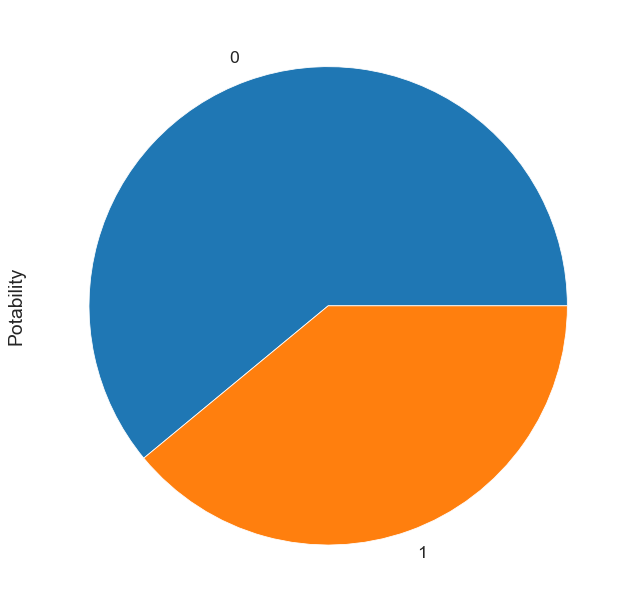

In [12]:
df.Potability.value_counts().plot(kind ='pie');

In [13]:
df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

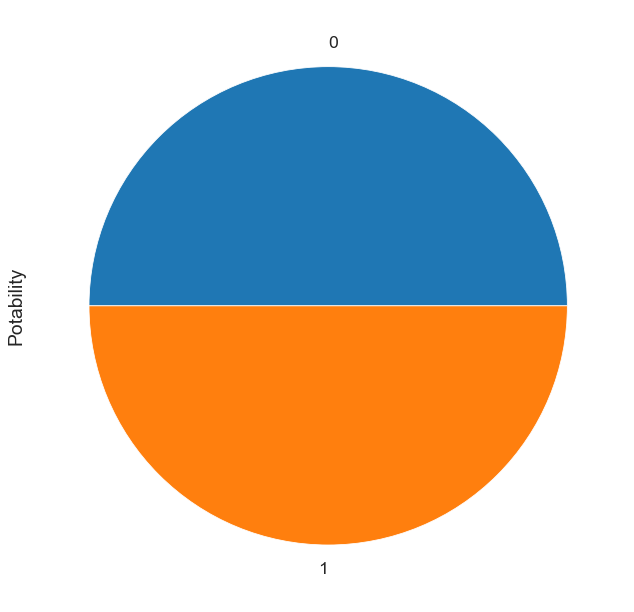

In [14]:
#Null values

zero  = df[df['Potability']==0]   #zero values in Potability column
one = df[df['Potability']==1]  # one values in Potability column
from sklearn.utils import resample
#minority class that  is 1, we need to upsample/increase that class so that there is no bias
#n_samples = 1998 means we want 1998 sample of class 1, since there are 1998 samples of class 0
df_minority_upsampled = resample(one, replace = True, n_samples = 1998) 
#concatenate
df = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle
df = shuffle(df) # shuffling so that there is particular sequence

df.Potability.value_counts().plot(kind ='pie');



In [30]:
from sklearn.impute import SimpleImputer
imp= SimpleImputer(strategy= 'mean')
r= imp.fit_transform(df[['ph']])
s= imp.fit_transform(df[['Sulfate']])
t= imp.fit_transform(df[['Trihalomethanes']])

df['ph']=r
df['Sulfate']= s
df['Trihalomethanes']=t

In [32]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [15]:
df.head(4)

ph    Hardness        Solids  Chloramines     Sulfate  \
122        NaN  230.809482  27418.781044     7.136498  369.310008   
2132       NaN  190.382604  30524.093791     6.375449  387.668609   
2080  5.585117  143.505413  22234.696738     9.252852  368.387465   
98    7.205559  120.327615  24627.867560     6.202469  289.768697   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
122     274.660597        9.578585        72.376909   4.197595           0  
2132    382.056758       19.195322        73.657806   4.938389           0  
2080    437.124665       11.575215        52.424378   4.148343           0  
98      418.433290       13.643147        63.733732   3.710053           0

<AxesSubplot:title={'center':'Missing Values Per Feature'}>

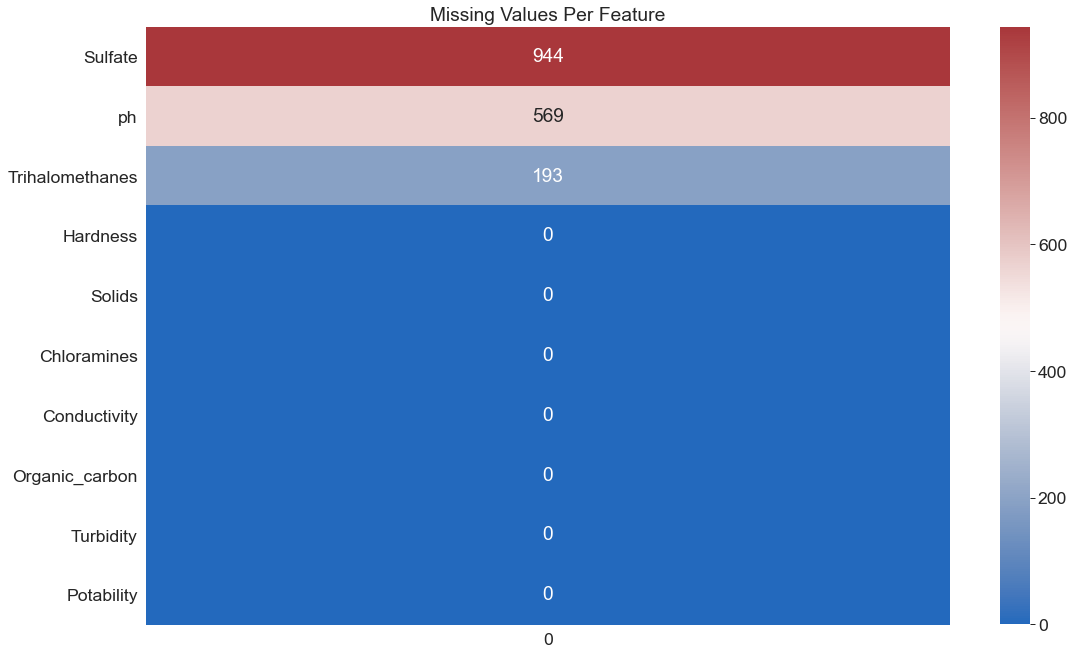

In [16]:
plt.title('Missing Values Per Feature')
nans = df.isna().sum().sort_values(ascending=False).to_frame()
sns.heatmap(nans,annot=True,fmt='d',cmap='vlag')

<AxesSubplot:>

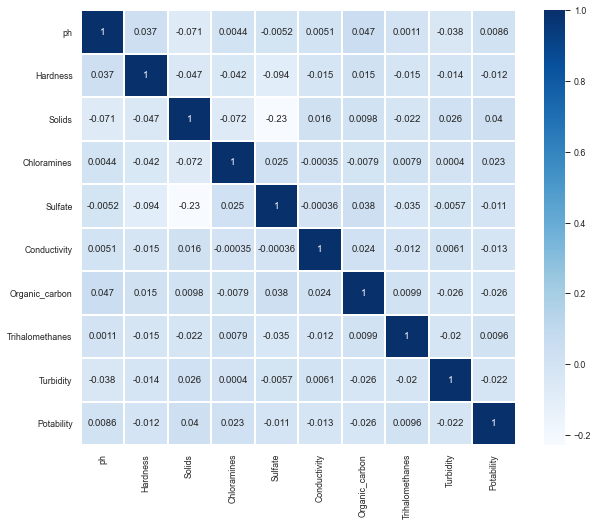

In [17]:
#Correlation

plt.figure(figsize=(10,8))
sns.set_context('paper')
sns.heatmap(df.corr(),cmap='Blues',linecolor='White',linewidth='1',annot=True,square=True)

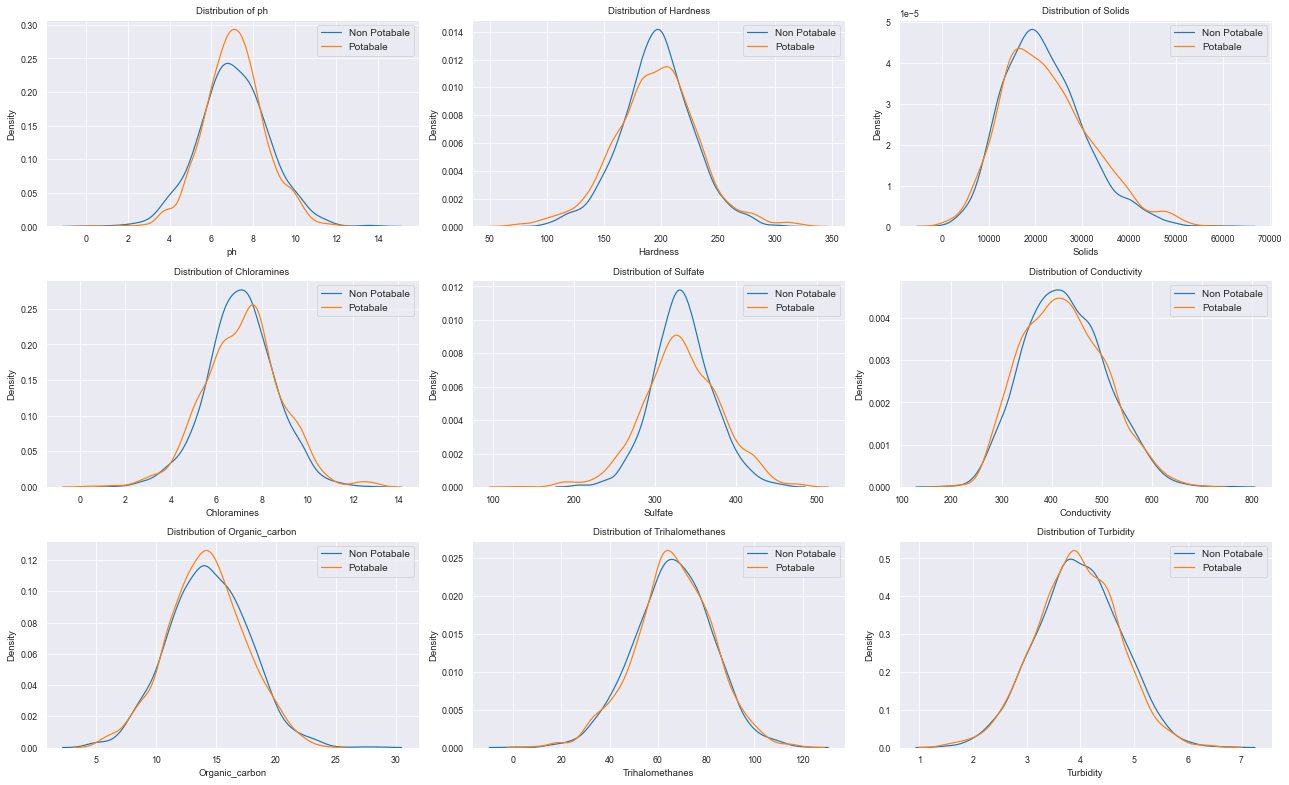

In [18]:
#EDA
non_potabale = df.query('Potability == 0')
potabale     = df.query('Potability == 1')

for ax,col in enumerate(df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(f'Distribution of {col}')
    sns.kdeplot(x=non_potabale[col],label='Non Potabale')
    sns.kdeplot(x=potabale[col],label='Potabale')
    plt.legend(prop=dict(size=10))
    

plt.tight_layout()

In [37]:
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=1/df.Turbidity.std(), testval=0)
    p = pm.Deterministic("p_parm", 1.0/(1. + tt.exp(beta*df.Turbidity + alpha)))
    


In [38]:
# with model:
#     observed = pm.Bernoulli("obs", p, observed=df.Potability)
#     start = pm.find_MAP()
#     step = pm.Metropolis()
#     trace = pm.sample(32000, step=step, start=start)
#     burned_trace = trace[20000::2]

C:\Users\swati\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

divide by zero encountered in log

C:\Users\swati\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning:

invalid value encountered in multiply



<ipython-input-38-427c31c9ef2e>:5: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


ValueError: Not enough samples to build a trace.

In [ ]:
#Probabilistic Distribution

alpha_samples = burned_trace["alpha"][:, None]
beta_samples = burned_trace["beta"][:, None]
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
sns.histplot(beta_samples, bins=35, alpha=0.85,label=r"posterior of $\beta$", palette=["#7A68A6"],stat='probability')
plt.legend()

plt.subplot(212)
sns.histplot(alpha_samples, bins=35, alpha=0.85,label=r"posterior of $\alpha$", palette=["#A60628"],stat='probability')
plt.legend();

In [ ]:
#Statistical difference analysis
ttest_results_pvalues,ttest_results_statistic = [],[]
for ax,col in enumerate(df.columns[:9]):
    statistic,pvalue = ttest_ind(non_potabale[col],potabale[col])
    ttest_results_pvalues.append(pvalue)
    ttest_results_statistic.append(statistic)
    
ttest_res_df = pd.DataFrame({'S':ttest_results_statistic,'P':ttest_results_pvalues,'F':df.columns[:9]})
ttest_res_df = ttest_res_df.sort_values(by='P')

In [ ]:
tr  = go.Bar(x=ttest_res_df['F'] ,y=ttest_res_df['P'] ,name='T-test P Value')
tr2 = go.Bar(x=ttest_res_df['F'] ,y=ttest_res_df['S'] ,name='T-test F Statistic')

data = [tr2,tr]
fig = go.Figure(data=data,layout={'title':'T-test Results For Each Feature in Our Dataset','barmode':'overlay'})
fig.show()

In [39]:
#Normalizing the data

X = df.iloc[:,:9].values
y = df.iloc[:,9:10].values
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
print('Normalized data:')
print(X[0])

Normalized data:
[-6.13160500e-16  1.01631893e+00  5.84872021e-01  4.57693036e-03
  9.44408994e-01 -1.86643583e+00 -1.43170206e+00  3.76351163e-01
  3.20932074e-01]


In [45]:
#Splitting the model
#Train test split of model

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 5)

In [46]:
#Building and fitting the model

#importing libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# creating the model

model= keras.Sequential([
    layers.Dense(128, input_shape= (9,), activation= 'relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation= 'relu'),
    layers.Dropout(0.4),
    layers.Dense(32, activation= 'relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation= 'sigmoid')
    
])

model.compile(
    optimizer= 'adam',
    loss= 'binary_crossentropy',
    metrics= ['accuracy']
) 
history= model.fit(X_train, y_train, epochs=400,validation_data=(X_test, y_test), verbose= False)
model.evaluate(X_train, y_train)

113/113 [==============================] - 0s 1ms/step - loss: 0.3231 - accuracy: 0.8910


[0.3230564594268799, 0.8909899592399597]

In [47]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1280      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [48]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 1ms/step - loss: 0.5329 - accuracy: 0.7225


[0.5328540205955505, 0.7225000262260437]

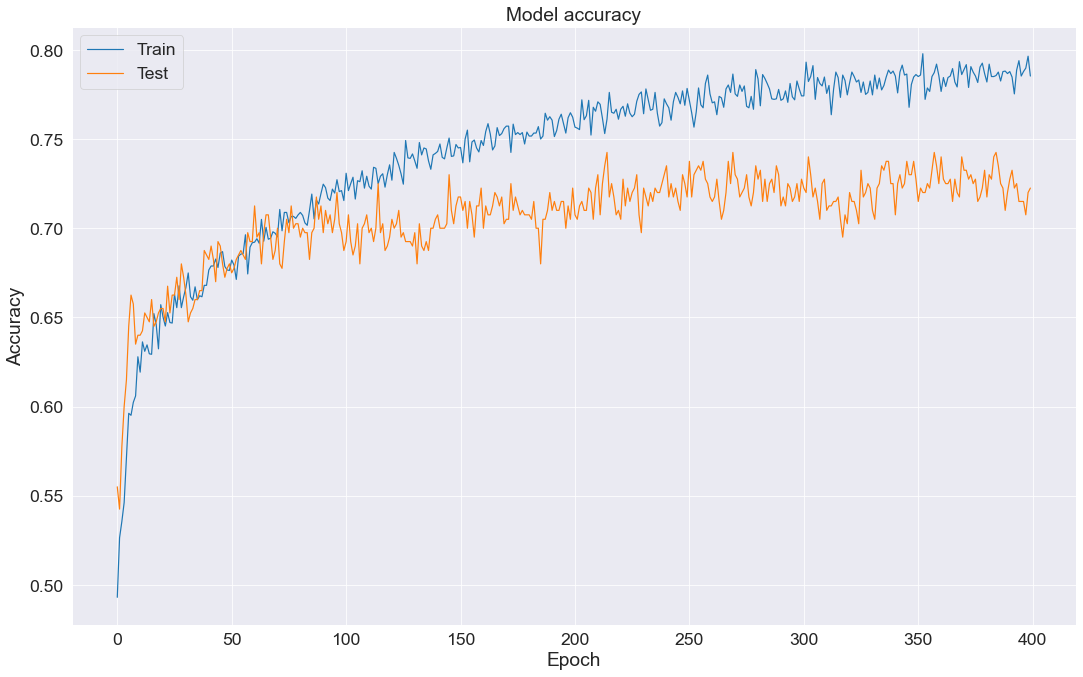

In [49]:
#Plotting accuracy and loss
# Model Accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

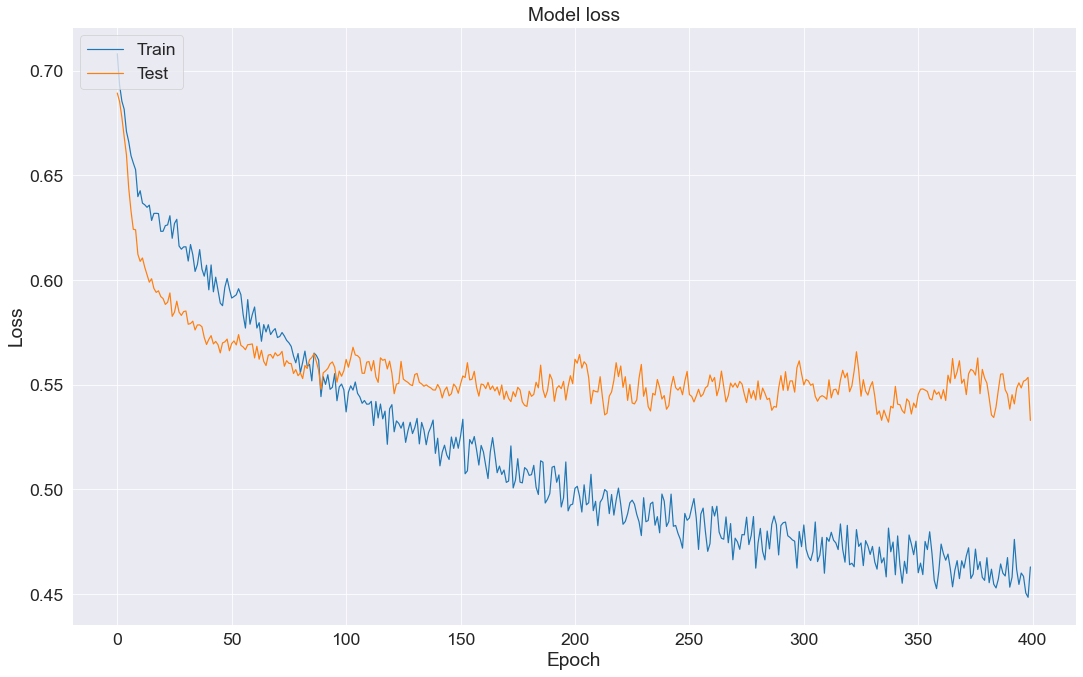

In [50]:
# Model Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [51]:
model.save('water_potability_test.h5')

In [52]:
#Model Predictions

from tensorflow.keras.models import load_model
m = load_model('water_potability_test.h5')
y_pred= model.predict(X_test)
y_pred = (y_pred>0.5)
y_pred[0:20]

array([[ True],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True]])

In [ ]:
#Anitha's code




In [ ]:
#Final Model

#Random Forest?

